In [1]:
import logging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import time
from pathlib import Path

import soundfile as sf
import torch
import yaml
import numpy as np
from prosody.utils.audio import *
from prosody.utils.utils import *
from prosody.transfer_prosody import *
from prosody.pinyin import *
from espnet2.text.phoneme_tokenizer import PhonemeTokenizer
from espnet2.text.token_id_converter import TokenIDConverter
from parallel_wavegan.utils import load_model as load_vocoder
from espnet2.bin.tts_inference import Text2Speech
from matplotlib import pyplot as plt

PWD = %pwd
PWD = Path(PWD)
COMBINED_DIR = (PWD / '../egs2/combined/tts1/').resolve()
LJSPEECH_DIR = (PWD / '../egs2/ljspeech/tts1/').resolve()
device = 'cuda'

In [25]:
%aimport prosody.utils.utils
%autoreload prosody.utils.utils
from prosody.utils import *

UsageError: Line magic function `%aimport` not found.


In [2]:
def get_pretrained(exp_name, corpus_dir=COMBINED_DIR, pth_file="latest.pth", config_file='config_prosody.yaml'):
    cwd = os.getcwd()
    os.chdir(corpus_dir)
    pretrained_dir = corpus_dir / "exp" / exp_name
    pretrained_model_file = pretrained_dir / pth_file
    pretrained_tts = Text2Speech.from_pretrained(
        train_config=pretrained_dir / config_file,
        model_file=pretrained_model_file,
        device=device
    )
    pretrained_model = pretrained_tts.model
    os.chdir(cwd)
    return pretrained_dir, pretrained_tts, pretrained_model

In [ ]:
pretrained_dir, pretrained_tts, pretrained_model = get_pretrained("tts_train_fastspeech2_prosody_raw_phn_none")

In [ ]:
pretrained_dir, pretrained_tts, pretrained_model = get_pretrained("fastspeech2_old")

In [3]:
pretrained_dir, pretrained_tts, pretrained_model = get_pretrained("tts_train_jets_raw_phn_tacotron_g2p_en_no_space", corpus_dir=LJSPEECH_DIR, pth_file='train.total_count.ave_5best.pth')

It seems weight norm is not applied in the pretrained model but the current model uses it. To keep the compatibility, we remove the norm from the current model. This may cause unexpected behavior due to the parameter mismatch in finetuning. To avoid this issue, please change the following parameters in config to false:
 - discriminator_params.follow_official_norm
 - discriminator_params.scale_discriminator_params.use_weight_norm
 - discriminator_params.scale_discriminator_params.use_spectral_norm

See also:
 - https://github.com/espnet/espnet/pull/5240
 - https://github.com/espnet/espnet/pull/5249


In [6]:
vocoder_ckpt = '/home/perry/PycharmProjects/vocoders/ljspeech_hifigan/checkpoint-2500000steps.pkl'
vocoder = load_vocoder(vocoder_ckpt)
vocoder.remove_weight_norm()
vocoder = vocoder.eval().to(device)

In [ ]:
orig_text = "Let's try something different."

In [ ]:
orig_text = "Do you have anything in mind"

In [ ]:
orig_text = "I thought you meant how old are you!"

In [ ]:
arpa_tokenizer = PhonemeTokenizer(g2p_type='g2p_en')
arpa_phones = arpa_tokenizer.g2p(orig_text)

In [4]:
arpa_tokenizer = PhonemeTokenizer(g2p_type='g2p_en_no_space')
id_converter = TokenIDConverter(pretrained_tts.train_args.token_list)

In [ ]:
utt_xvectors = read_xvectors(COMBINED_DIR, "dump/xvector/eval1_phn/xvector.scp")

In [21]:
spk_xvectors = read_xvectors(COMBINED_DIR, "dump/xvector/tr_no_dev_phn/spk_xvector.ark")

In [24]:
arpa_phones = arpa_tokenizer.text2tokens(orig_text)
phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)

In [25]:
phone_ids.shape

torch.Size([36])

In [5]:
save_dir = PWD / 'outputs' / pretrained_dir.stem
def save_wav(orig_text, model=pretrained_model, tokenizer=arpa_tokenizer, converter=id_converter, **kwargs):
    arpa_phones = tokenizer.text2tokens(orig_text)
    phone_ids = torch.IntTensor(converter.tokens2ids(arpa_phones)).to(device)
    if 'sids' in kwargs:
        sids = kwargs.pop('sids')
        suffix = str(sids[0])
        sids = torch.tensor(sids, device=device)
        spembs = None
    else:
        sids = None
        if 'spk' in kwargs:
            spk = kwargs.pop('spk')
            xvector_dict = spk_xvectors
            spembs = torch.tensor(xvector_dict[spk]).to(device).squeeze()
            suffix = str(spk)
        else:
            if 'suffix' in kwargs:
                suffix = kwargs.pop('suffix')
            else:
                suffix = ''
            spembs = None

    with torch.no_grad():
        if hasattr(pretrained_model.tts, 'generator'):
            wav, output_dic = model.tts.generator.inference(
                text=phone_ids[None],
                text_lengths=torch.tensor([len(phone_ids)]),
                sids=sids, spembs=spembs, **kwargs
            )
            wav = wav.view(-1)
        else:
            output_dic = model.tts.inference(text=phone_ids, sids=sids, spembs=spembs, **kwargs)
            mel = output_dic['feat_gen']
            wav = vocoder.inference(mel, normalize_before=False).view(-1)

    os.makedirs(save_dir, exist_ok=True)

    # save as PCM 16 bit wav file
    sf.write(
        save_dir / f"{clean_filename(orig_text)}_{suffix}.wav",
        wav.detach().cpu().numpy(),
        22050,
        "PCM_16",
    )
    return output_dic

In [ ]:
arpa_phones = arpa_tokenizer.text2tokens(orig_text)

In [ ]:
from matplotlib import pyplot as plt
def plot_pitch(wav_path, model=pretrained_model):
    with open(wav_path, 'rb') as f:
        audio, _ = sf.read(f)
        inp = torch.tensor([audio], device=device)
    feats, _ = model.feats_extract(torch.tensor(inp, dtype=torch.float, device=device))
    feats_lengths = torch.tensor([feats.shape[1]], device=device)
    model.pitch_extract.use_token_averaged_f0 = False
    pitch, pitch_lengths = model.pitch_extract(inp, feats_lengths=feats_lengths)
    model.pitch_extract.use_token_averaged_f0 = True
    plt.plot(pitch.squeeze().cpu().numpy())
    return feats, feats_lengths, pitch, pitch_lengths

In [ ]:
feats, feats_length, pitch, pitch_lengths = plot_pitch('/home/perry/PycharmProjects/ESD/0018/Surprise/test/0018_001423.wav')

In [ ]:
save_wav(orig_text, spk='0012')
# save_wav(orig_text, spk='0018', p_factor=torch.tensor([0.3], device=device))
# save_wav(orig_text, spk='0018', p_factor=torch.tensor([0.3], device=device), d_factor=torch.tensor([0.8], device=device))

In [6]:
long_surprise_texts = [
    'Why do all your coffee mugs have numbers on the bottom?',
    'Okay, so you were trying to play bad this whole time.',
    "Rach, I'm sorry, but you didn't give me any contracts!"
]
short_surprise_texts = [
    "They're not listening to me?",
    'Wow, you guys, this is big.',
    "It's nine o'clock in the morning!",
]
long_sad_texts = [
    "Oh come on, what am I gonna do, its been hours and it won't stop crying.",
    'I guess I just figured that somewhere down the road, we would be on again.',
    'No, I had to return it to the costume place.'
]
short_sad_texts = [
    'Can we please turn this off?',
    "I mean, no, you're right.",
    "Well it's very unsettling."
]
input_texts = long_surprise_texts + short_surprise_texts + long_sad_texts + short_sad_texts

In [7]:
short_surprise_ref = [
    '/home/perry/PycharmProjects/ESD_22050_en/0016/Surprise/test/0016_001449.wav',
    '/home/perry/PycharmProjects/ESD_22050_en/0017/Surprise/test/0017_001447.wav',
    '/home/perry/PycharmProjects/ESD_22050_en/0018/Surprise/test/0018_001421.wav',
]
long_surprise_ref = [
    '/home/perry/PycharmProjects/ESD_22050_en/0016/Surprise/test/0016_001450.wav',
    '/home/perry/PycharmProjects/ESD_22050_en/0017/Surprise/test/0017_001428.wav',
    '/home/perry/PycharmProjects/ESD_22050_en/0018/Surprise/test/0018_001440.wav'
]
short_sad_ref = [
    '/home/perry/PycharmProjects/ESD_22050_en/0016/Sad/test/0016_001091.wav',
    '/home/perry/PycharmProjects/ESD_22050_en/0017/Sad/test/0017_001086.wav',
    '/home/perry/PycharmProjects/ESD_22050_en/0018/Sad/test/0018_001092.wav',
]
long_sad_ref = [
    '/home/perry/PycharmProjects/ESD_22050_en/0016/Sad/test/0016_001090.wav',
    '/home/perry/PycharmProjects/ESD_22050_en/0017/Sad/test/0017_001078.wav',
    '/home/perry/PycharmProjects/ESD_22050_en/0018/Sad/test/0018_001084.wav'
]
ref_wavs = short_surprise_ref + long_surprise_ref + short_sad_ref + long_sad_ref

In [12]:
%load_ext autoreload
%autoreload 2


In [8]:
from espnet2.tts.feats_extract.praat_pitch import PraatPitch
pretrained_model.pitch_extract = PraatPitch(use_token_averaged_f0=False)
pretrained_model.pitch_extract.stft_pad = 256

In [15]:
wav_path = '/home/perry/PycharmProjects/ESD_22050_en/0018/Happy/train/0018_001050.wav'
(
    speech, speech_lengths,
    feats, feats_lengths,
    pitch, pitch_lengths,
    energy, energy_lengths,
    voiced_frames
) = extract_all_feats(wav_path, pretrained_model)
normed_pitch, normed_energy = normalize_feats(pretrained_model, pitch, pitch_lengths, energy, energy_lengths)

In [74]:
phone_ids.shape

torch.Size([36])

In [11]:
from prosody.utils.text import ARPA_VOWELS, PUNCS
import time

start = time.time()
for orig_text, wav_path in zip(input_texts, ref_wavs):

    suffix = 'ref' + wav_path.split('/')[-1].split('.')[0]

    # orig_text = 'Do you have anything in mind?'
    # wav_path = '/home/perry/PycharmProjects/ESD_22050_en/0018/Happy/train/0018_001050.wav'

    (
        speech, speech_lengths,
        feats, feats_lengths,
        pitch, pitch_lengths,
        energy, energy_lengths,
        voiced_frames
    ) = extract_all_feats(wav_path, pretrained_model)
    normed_pitch, normed_energy = normalize_feats(pretrained_model, pitch, pitch_lengths, energy, energy_lengths)

    arpa_phones = arpa_tokenizer.text2tokens(orig_text)
    phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)
    # with torch.no_grad():
    #     output_dict = pretrained_model.tts.inference(
    #         text=phone_ids,
    #         sids=torch.tensor([8], device=device),
    #         # spembs=torch.tensor(spk_xvectors['0018']).squeeze().to(device)
    #     )
    with torch.no_grad():
        output_dict = pretrained_model.tts.generator.inference(
            text=phone_ids[None], text_lengths=torch.tensor([len(phone_ids)])
        )

    is_vowels = [p in ARPA_VOWELS for p in arpa_phones]
    is_consonants = [p not in ARPA_VOWELS and p not in PUNCS for p in arpa_phones]
    if not hasattr(pretrained_model.tts, 'generator'):  # got eos
        is_vowels.append(False)
        is_consonants.append(False)

    is_vowels = torch.tensor(is_vowels, device=device)
    is_consonants = torch.tensor(is_consonants, device=device)

    transfer_prosody_args = {
        'voiced_frames': voiced_frames,
        'normed_pitch': normed_pitch,
        'normed_energy': normed_energy,
        'is_vowels': is_vowels,
        'is_consonants': is_consonants,
        # 'change_durations': True,
        'scale_energy': True,
    }
    # force_prosody_args = {
    #     'pitch_new': pitch_new_adj,
    #     'energy_new': energy_new_adj,
    # }
    output_dict = save_wav(
        orig_text,
        suffix=suffix,
        # sids=[8],
        # spk='0018',
        verbose=True,
        # d_factor=0.7,
        transfer_prosody_args=transfer_prosody_args,
        # force_prosody_args=force_prosody_args,
        e_ref_weight=1.0,
        p_ref_weight=1.0
    )
print(time.time() - start)

Duration pred: tensor([ 9.7040,  9.1171,  9.4322, 12.5122, 13.4068,  8.8799,  7.3288,  5.1744,
         7.8569, 10.1360, 10.2096, 11.4694,  7.6856,  7.4427,  9.2418,  9.7072,
         5.1550,  5.3405,  6.7522,  6.5406,  5.6568,  5.1344,  5.1470,  5.1855,
         7.4596, 11.4276,  6.1587,  5.6664,  4.9827,  6.1949,  7.0202,  8.7912,
         6.1483,  5.9203,  6.6067,  8.6886], device='cuda:0')
Pitch pred: tensor([ 0.3623,  0.3205,  0.4578,  0.5322,  0.4711,  0.2223, -0.0153, -0.0637,
        -0.0533,  0.4264,  0.6241,  0.5885,  0.0792, -0.5792, -0.9162, -0.6146,
        -0.3884, -0.0316, -0.1082, -0.0261,  0.2999,  0.7878,  0.6313,  0.1778,
        -0.0753, -0.0865, -0.3712, -0.6123, -0.5619, -0.6559, -0.0666,  0.1705,
         0.0826, -0.0524, -0.0161, -0.0534], device='cuda:0')
Energy pred: tensor([ 1.5953,  3.1012,  0.5644,  0.4974,  1.7838,  0.6515,  0.3003,  1.1116,
        -0.4013, -0.3801,  1.4301, -0.5634,  0.2457,  0.5503,  0.5040, -0.4734,
        -0.0753, -0.2780,  0.2203, -

In [17]:
pitch_pred = torch.tensor([ 0.3294,  0.3965,  0.4839,  0.5100,  0.5825,  0.5105,  0.4166,  0.4191,
         0.3414,  0.3305,  0.3260,  0.4335,  0.4762,  0.3412,  0.2971,  0.2649,
         0.2958,  0.3493,  0.3799,  0.3334,  0.3755,  0.4199,  0.3489,  0.2135,
         0.2984,  0.4799,  0.8018,  0.3095,  0.3472,  0.4043,  0.2839,  0.3488,
         0.3095,  0.2456,  0.0646,  0.0440, -6.0043], device='cuda:0')[None].unsqueeze(-1)
energy_pred = torch.tensor([-1.1779,  1.1396, -0.2985, -0.1988,  0.4161,  0.5602, -0.1610,  0.0887,
         0.2753, -0.9029,  0.4417, -0.8579, -0.2328, -0.4055,  0.3009, -0.6107,
        -1.0336, -0.9459,  0.3239, -0.4682, -0.6070,  0.0524, -0.2879, -0.7138,
         0.2443, -0.6832, -0.3042, -0.2709, -0.5418, -0.0505, -0.7004,  0.1891,
        -0.7554, -0.6725, -0.8909, -1.1958, -1.1978], device='cuda:0')[None].unsqueeze(-1)
pitch_new = torch.tensor([0.6686, 0.6310, 0.5494, 0.7547, 0.3575, 0.3547, 0.4444, 0.4232, 0.4450,
        0.5024, 1.2599, 0.9181, 0.6310, 0.6331, 0.7547, 0.8974, 0.8086, 0.4371,
        0.3575, 0.3516, 0.4546, 0.4232, 0.4511, 0.5361, 1.2599, 0.5889, 0.7547,
        0.8938, 0.4327, 0.3575, 0.3525, 0.4232, 0.4789, 1.2599, 1.2886, 0.0000,
        0.0000], device='cuda:0')[None].unsqueeze(-1)
energy_new = torch.tensor([-1.0925,  1.6833,  0.5696,  2.6328,  2.4530,  0.7761,  3.6973,  6.4470,
         4.0459,  2.2143,  4.4924, -0.9525,  1.6833,  0.2139,  2.6328, -0.7367,
         1.0891,  1.2825,  2.4530,  1.5138,  2.2525,  6.4470,  3.6472,  2.2036,
         4.4924,  0.1997,  2.6328,  0.6111,  1.2773,  2.4530,  1.1194,  6.4470,
         2.7510,  4.4924,  3.4840,  0.0000,  0.0000], device='cuda:0')[None].unsqueeze(-1)

In [23]:
energy_new.mean() - energy_pred.mean()

In [24]:
energy_new.std()

19.2

In [36]:
energy_pred.std()

tensor(0.5604, device='cuda:0')

In [38]:
pitch_new_adj = pitch_new - (pitch_new.mean() - pitch_pred.mean())
energy_new_adj = energy_new / energy_new.std() * energy_pred.std()

In [10]:
normed_pitch = normed_pitch.squeeze()
normed_energy = normed_energy.squeeze()
is_peaks, nonzero_starts, nonzero_ends = find_peaks(normed_energy, voiced_frames)
voiced_energy = normed_energy[voiced_frames]
voiced_pitch = normed_pitch[voiced_frames]
voiced_peaks = is_peaks[voiced_frames]
peaks = voiced_peaks.nonzero().squeeze()
num_peaks = len(peaks)
num_vowels = sum(is_vowels).item()
if num_peaks < num_vowels:
    repeats = compute_repeats(num_vowels, num_peaks)
    peaks, voiced_pitch, voiced_energy = repeat_peaks(repeats, peaks, num_peaks, voiced_pitch, voiced_energy)
    num_peaks = num_vowels
elif num_peaks > num_vowels:
    peaks = retain_peaks(peaks, len(voiced_energy), duration_pred, is_vowels)
energy_new = torch.zeros_like(energy_pred)
energy_new[is_vowels] = voiced_energy[peaks]
pitch_new = torch.zeros_like(pitch_pred)
pitch_new[is_vowels] = voiced_pitch[peaks]

[Text(0, 0, 'W'),
 Text(1, 0, 'AY1'),
 Text(2, 0, 'D'),
 Text(3, 0, 'UW1'),
 Text(4, 0, 'AO1'),
 Text(5, 0, 'L'),
 Text(6, 0, 'Y'),
 Text(7, 0, 'AO1'),
 Text(8, 0, 'R'),
 Text(9, 0, 'K'),
 Text(10, 0, 'AA1'),
 Text(11, 0, 'F'),
 Text(12, 0, 'IY0'),
 Text(13, 0, 'M'),
 Text(14, 0, 'AH1'),
 Text(15, 0, 'G'),
 Text(16, 0, 'Z'),
 Text(17, 0, 'HH'),
 Text(18, 0, 'AE1'),
 Text(19, 0, 'V'),
 Text(20, 0, 'N'),
 Text(21, 0, 'AH1'),
 Text(22, 0, 'M'),
 Text(23, 0, 'B'),
 Text(24, 0, 'ER0'),
 Text(25, 0, 'Z'),
 Text(26, 0, 'AA1'),
 Text(27, 0, 'N'),
 Text(28, 0, 'DH'),
 Text(29, 0, 'AH0'),
 Text(30, 0, 'B'),
 Text(31, 0, 'AA1'),
 Text(32, 0, 'T'),
 Text(33, 0, 'AH0'),
 Text(34, 0, 'M'),
 Text(35, 0, '?')]

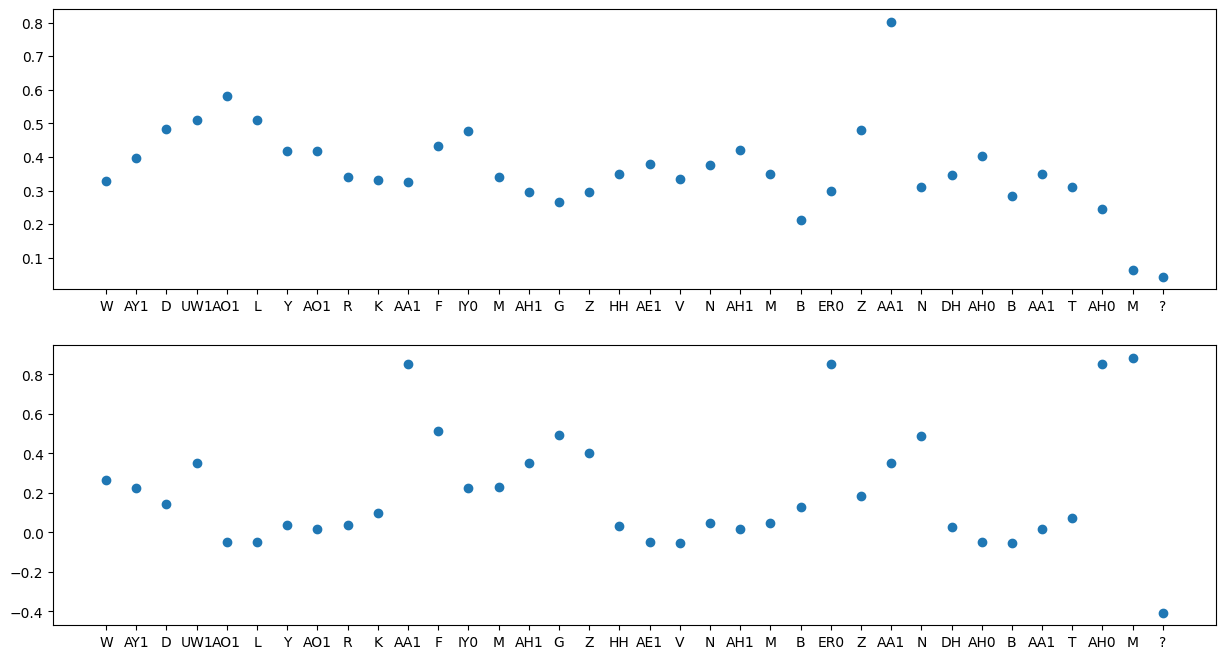

In [33]:
f, axs = plt.subplots(2, 1, figsize=(15, 8))
axs[0].scatter(range(pitch_pred.shape[1]-1), pitch_pred.squeeze().cpu()[:-1])
axs[1].scatter(range(pitch_new_adj.shape[1]-1), pitch_new_adj.squeeze().cpu()[:-1])
axs[0].set_xticks(range(len(arpa_phones)))
axs[0].set_xticklabels(arpa_phones)
axs[1].set_xticks(range(len(arpa_phones)))
axs[1].set_xticklabels(arpa_phones)

[Text(0, 0, 'W'),
 Text(1, 0, 'AY1'),
 Text(2, 0, 'D'),
 Text(3, 0, 'UW1'),
 Text(4, 0, 'AO1'),
 Text(5, 0, 'L'),
 Text(6, 0, 'Y'),
 Text(7, 0, 'AO1'),
 Text(8, 0, 'R'),
 Text(9, 0, 'K'),
 Text(10, 0, 'AA1'),
 Text(11, 0, 'F'),
 Text(12, 0, 'IY0'),
 Text(13, 0, 'M'),
 Text(14, 0, 'AH1'),
 Text(15, 0, 'G'),
 Text(16, 0, 'Z'),
 Text(17, 0, 'HH'),
 Text(18, 0, 'AE1'),
 Text(19, 0, 'V'),
 Text(20, 0, 'N'),
 Text(21, 0, 'AH1'),
 Text(22, 0, 'M'),
 Text(23, 0, 'B'),
 Text(24, 0, 'ER0'),
 Text(25, 0, 'Z'),
 Text(26, 0, 'AA1'),
 Text(27, 0, 'N'),
 Text(28, 0, 'DH'),
 Text(29, 0, 'AH0'),
 Text(30, 0, 'B'),
 Text(31, 0, 'AA1'),
 Text(32, 0, 'T'),
 Text(33, 0, 'AH0'),
 Text(34, 0, 'M'),
 Text(35, 0, '?')]

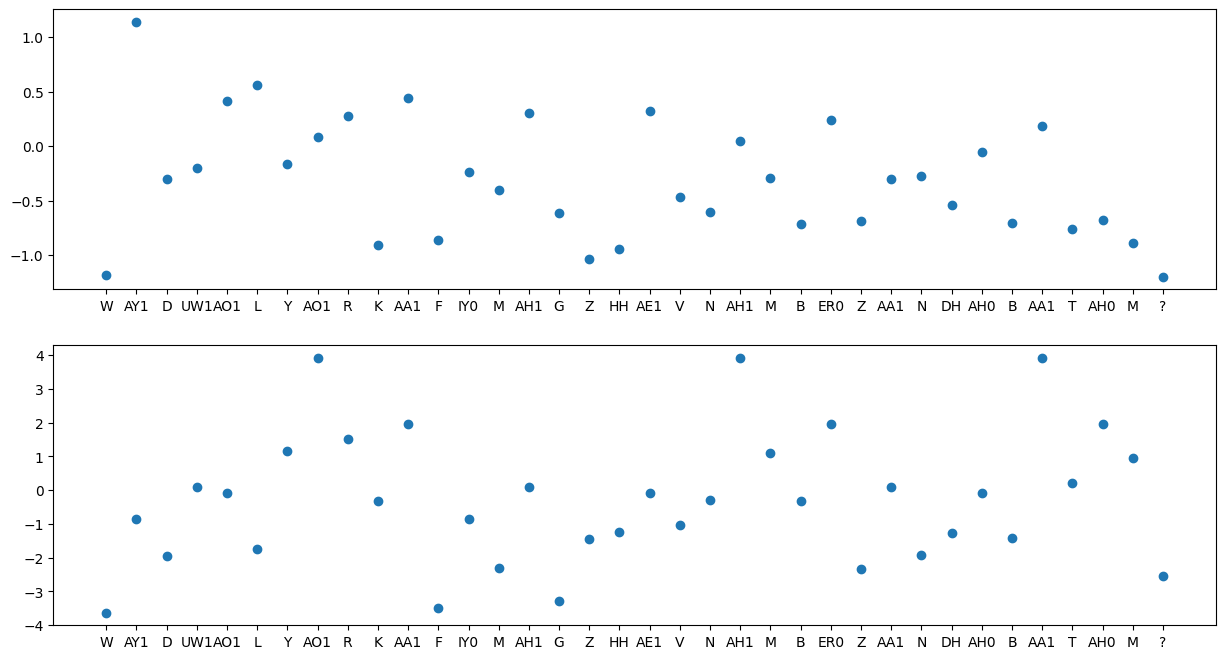

In [34]:
f, axs = plt.subplots(2, 1, figsize=(15, 8))
axs[0].scatter(range(energy_pred.shape[1]-1), energy_pred.squeeze().cpu()[:-1])
axs[1].scatter(range(energy_new_adj.shape[1]-1), energy_new_adj.squeeze().cpu()[:-1])
axs[0].set_xticks(range(len(arpa_phones)))
axs[0].set_xticklabels(arpa_phones)
axs[1].set_xticks(range(len(arpa_phones)))
axs[1].set_xticklabels(arpa_phones)

In [15]:
pitch_pred[:-1].mean()

tensor(0.3643, device='cuda:0')

In [12]:
durations = output_dict['duration']
arpa_phones = arpa_tokenizer.text2tokens(orig_text)
phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)
print_table(arpa_phones=arpa_phones, durations=durations)

    -1        0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35     36
arpa_phones   W   AY1   D   UW1  AO1   L    Y   AO1   R    K   AA1    F    IY0    M    AH1    G     Z     HH   AE1    V     N    AH1    M     B    ER0    Z    AA1    N     DH   AH0    B    AA1    T    AH0    M     ?
 durations   26   12    8    9   13    5   10    5    6   13    9     8     7     8     8     5     9     1     7     7     7     7     6     4     11    8     12    7     1     4     8     10    9     10    11    30      0


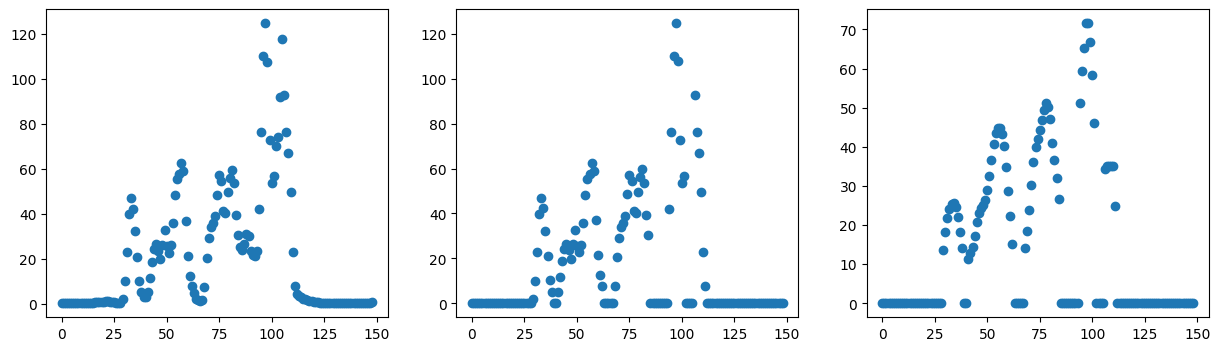

In [78]:
f, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].scatter(range(energy.shape[1]), energy.squeeze().cpu())
axs[1].scatter(range(voiced_energy.shape[1]), voiced_energy.squeeze().cpu())
axs[2].scatter(range(len(avg_energy)), torch.where(pitch.squeeze() > 0.0, avg_energy, 0.0).squeeze().cpu())

In [33]:
from scipy.signal import find_peaks as scipy_find_peaks, find_peaks_cwt
peaks = scipy_find_peaks(energy[pitch > 0.0].squeeze().cpu().numpy(), width=4)

In [13]:
e_array = voiced_energy.squeeze()
def get_splits(e_array):
    e_right = shift_pad(e_array, 1, pad=1)
    e_left = shift_pad(e_array, -1, pad=-1)
    nonzero_starts = ((e_array != 0.0) & (e_right == 0.0)).nonzero().squeeze()
    nonzero_ends = ((e_array != 0.0) & (e_left == 0.0)).nonzero().squeeze()
    assert len(nonzero_starts) == len(nonzero_ends)
    splits = []
    for nonzero_start, nonzero_end in zip(nonzero_starts, nonzero_ends):
        splits.append(e_array[nonzero_start:nonzero_end+1])
    return splits, nonzero_starts, nonzero_ends

NameError: name 'voiced_energy' is not defined

In [98]:
splits, nonzero_starts, nonzero_ends = get_splits(e_array)

In [74]:
np.pad([1, 1], 1).tolist()

[0, 1, 1, 0]

In [64]:
sum(len(s) for s in splits)

63

In [99]:
peaks = []
for split, nonzero_start in zip(splits, nonzero_starts.cpu().numpy()):
    split_peaks = scipy_find_peaks(np.pad(split.cpu().numpy(), 1), width=3)[0]
    for split_peak in split_peaks:
        peaks.append(split_peak + nonzero_start - 1)

In [ ]:
peaks

92.812386

In [93]:
(avg_energy > avg_energy_left).nonzero().squeeze()

tensor([ 34,  35,  36,  37,  38,  39,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  98,
         99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115],
       device='cuda:0')

In [95]:
(avg_energy > avg_energy_right).nonzero().squeeze()

tensor([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  90,  91,  92,  93,
         94,  95,  96,  97, 107], device='cuda:0')

In [99]:
pitch.squeeze().nonzero().squeeze()

tensor([ 29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  94,  95,  96,  97,  98,  99, 100,
        101, 106, 107, 108, 109, 110, 111], device='cuda:0')

In [96]:
(avg_energy > 0.0).nonzero().squeeze()

tensor([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115], device='cuda:0')

In [90]:
peaks

tensor([34, 55, 78], device='cuda:0')

In [ ]:
is_vowels = torch.tensor([p in ARPA_VOWELS for p in arpa_phones], device=device)
is_consonants = torch.tensor([p not in ARPA_VOWELS and p not in PUNCS for p in arpa_phones], device=device)

In [ ]:
pitch.shape

In [ ]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem

In [ ]:
with torch.no_grad():
    output_dict = pretrained_model.tts.generator.inference(
        text=phone_ids.unsqueeze(0), text_lengths=torch.tensor([len(phone_ids)], device=device),
        verbose=True,
    )
sf.write(save_dir / 'transfer' / f'{custom_text}.wav',
         output_dict[0].squeeze().cpu().numpy(), 22050, "PCM_16")

In [ ]:
questions = ['What are you working on?']
gts = ['/home/perry/PycharmProjects/dailytalk/data/0/0_1_d0.wav']

In [ ]:
questions = ["Did you bring some lunch with you?"]
gts = ['/home/perry/PycharmProjects/dailytalk/data/3/0_1_d3.wav']

In [ ]:
from shutil import copyfile
save_dir = Path('/home/perry/firebase3/public/questions/')

In [ ]:
orig_feats = extract_normalized_feats(save_dir / 'transfer' / f'{custom_text}.wav', pretrained_tts=pretrained_tts)

In [ ]:

for question, gt in zip(questions, gts):
    with torch.no_grad():
        fname = re.sub(r'[^A-Za-z ]', '', question).replace(' ', '_')
        arpa_phones = arpa_tokenizer.text2tokens(question)
        phonemes, phone_ids, d_factor, p_factor, e_factor, d_split_factor = get_inputs(question, tokens2ids_fn=id_converter.tokens2ids)
        wav, _, _ = pretrained_model.tts.generator.inference(
            text=phone_ids.unsqueeze(0), text_lengths=torch.tensor([len(phone_ids)], device=device),
            verbose=True,
        )
        sf.write(save_dir / 'jets' /  f'{fname}.wav', wav.squeeze().cpu().numpy(), 22050, "PCM_16")
        wav_modified, _, _ = pretrained_model.tts.generator.inference(
            text=phone_ids.unsqueeze(0), text_lengths=torch.tensor([len(phone_ids)], device=device),
            p_factor=p_factor,
            verbose=True,
        )
        sf.write(save_dir / 'present' /  f'{fname}.wav', wav_modified.squeeze().cpu().numpy(), 22050, "PCM_16")
        copyfile(gt, save_dir / 'dailytalk' /  f'{fname}.wav')

In [46]:
from espnet2.gan_tts.jets.generator import *

In [88]:
e_reference = energy.squeeze(-1)
p_reference = pitch.squeeze(-1)
avg_energy = compute_avg_energy(e_reference, duration_pred, window=9)
e_threshold = threshold(10.0)

In [27]:
is_vowels.sum()

tensor(15, device='cuda:0')

In [56]:
avg_energy = compute_avg_energy(e_reference, duration_pred, window=8)
energy = avg_energy.clone()
keep_frames = energy > e_threshold
energy = energy[keep_frames]
pitch = p_reference.squeeze()[keep_frames]
peaks = find_peaks(energy)

In [58]:
len(peaks)

10

In [15]:
energy = avg_energy.clone()
keep_frames = energy > threshold(10.0)
energy = energy[keep_frames]
peaks = find_peaks(energy)
num_peaks = len(peaks)
num_vowels = sum(is_vowels).item()

In [40]:
repeats = compute_repeats(num_vowels, num_peaks)
peaks_new, pitch_new, energy_new = repeat_peaks_(repeats, peaks, num_peaks, pitch, energy)

152
246


In [29]:
len(energy)

197

In [44]:
find_peaks(energy_new)

tensor([  6,  37,  56,  78,  90, 116, 121, 145, 165, 170, 194, 206, 212, 238,
        243], device='cuda:0')

In [43]:
peaks_new

tensor([  6,  37,  56,  78,  90, 116, 121, 145, 165, 170, 194, 206, 212, 238,
        243], device='cuda:0')

In [38]:
peaks[-7:]

tensor([116, 121, 145, 157, 163, 189, 194], device='cuda:0')

In [25]:
peaks = find_peaks(energy)

In [32]:
peaks

tensor([ 5, 17, 36, 52, 69, 74, 80, 97], device='cuda:0')

In [33]:
energy_mask = avg_energy > threshold(10.0)
start = 0
while not energy_mask[start]:
    start += 1
end = -1
while not energy_mask[end]:
    end -= 1
ref_actual_len = len(avg_energy) - start + end + 1

In [34]:
ref_actual_len / len(peaks) * 22050/16000

18.6046875

In [32]:
157 / len(peaks)

15.7

In [24]:
(peaks[-1] - peaks[0]) / (len(peaks)-1)

tensor(14.6667, device='cuda:0')

In [28]:
energy_mask = avg_energy > threshold(0.0)
ref_frames = len(energy_mask)
start = 0
while not energy_mask[start]:
    start += 1
end = -1
while not energy_mask[end]:
    end -= 1

In [46]:
len(avg_energy)

157

In [29]:
actual_len = len(avg_energy) - start + end + 1

In [30]:
actual_len

157

In [50]:
sum(energy_mask)

tensor(130, device='cuda:0')

In [31]:
duration_pred.sum() / sum(is_vowels)

tensor(22.4667, device='cuda:0')

In [29]:
out_feats = extract_normalized_feats(out_path)

In [41]:
gener_feats = extract_normalized_feats(f'/home/perry/PycharmProjects/GenerSpeech/infer_out/{custom_text}-ref{ref_filename}.wav')

In [35]:
from espnet2.gan_tts.jets.alignments import average_by_duration
p_outs = average_by_duration(
                duration_pred.unsqueeze(0), orig_pitch.unsqueeze(0), torch.tensor([len(phone_ids)], device=device), orig_feats[3]
            ).unsqueeze(-1)

In [179]:
pitch.shape

torch.Size([94])

In [15]:
def normalize_to_pred(reference, pred):
    min_pred = pred.min()
    scale = (pred.max() - min_pred) / (reference.max() - reference.min())
    scaled_ref = reference * scale
    reference = scaled_ref - scaled_ref.min() + min_pred
    return reference

In [16]:
avg_energy = normalize_to_pred(avg_energy, energy_pred)
pitch = normalize_to_pred(pitch, pitch_pred)

In [19]:
num_vowels = is_vowels.sum().item()

In [21]:
avg_energy_left = shift_pad(avg_energy, -1)
avg_energy_right = shift_pad(avg_energy, 1)

In [22]:
peaks = torch.nonzero((avg_energy > avg_energy_left) & (avg_energy > avg_energy_right)).squeeze()

In [23]:
num_peaks = len(peaks)

In [24]:
if num_peaks < num_vowels:
    scale = math.ceil(num_vowels / num_peaks)
    peaks = torch.flatten(peaks + torch.arange(scale, device=device).unsqueeze(1) * len(avg_energy))
    avg_energy = avg_energy.repeat(scale)
    pitch = pitch.repeat(scale)

In [25]:
energy_new = energy_pred.clone()

In [26]:
energy_new[is_vowels] = avg_energy[peaks]

In [27]:
pitch_new = pitch_pred.clone()
pitch_new[is_vowels] = pitch[peaks]

In [28]:
vowel_indices = torch.nonzero(is_vowels).squeeze()

In [29]:
duration_start = shift_pad(duration_pred.cumsum(0), shift=1)

In [30]:
phone_positions = duration_start + duration_pred / 2

In [31]:
def add_start_end(x, start_value, end_value):
    y = torch.zeros(len(x)+2, dtype=x.dtype, device=x.device)
    y[0] = start_value
    y[1:-1] = x
    y[-1] = end_value
    return y

In [32]:
phone_positions = add_start_end(phone_positions, 0, duration_pred.sum())

In [33]:
vowel_positions = add_start_end(phone_positions[1:-1][is_vowels], 0, phone_positions[-1])

In [34]:
vowel_indices = torch.nonzero(is_vowels).squeeze()
vowel_indices = add_start_end(vowel_indices, -1, len(duration_pred))

In [35]:
vowel_indices

tensor([-1,  1,  3,  5,  7, 10, 12, 15, 19, 22, 24, 28, 30, 34, 37, 40, 43],
       device='cuda:0')

In [36]:
phone_positions = add_start_end(phone_positions, 0, duration_pred.sum())

In [37]:
peaks = add_start_end(peaks, 0, len(avg_energy))

In [41]:
pitch_pred.squeeze()

tensor([ 1.0081,  1.6838,  1.6185,  1.3124,  1.0328,  0.6366,  0.4254,  0.5206,
         0.3145, -0.0381, -0.2157,  0.0195, -0.3340, -0.4843, -0.3955, -0.4867,
        -0.2431, -0.3562, -0.3014, -0.1122,  0.0362,  0.0138, -0.3176, -0.2748,
        -0.1264,  0.0293,  0.0540,  0.2609,  0.2613,  0.3070, -0.4706, -0.5565,
        -0.3059,  0.0631,  0.0668,  0.2042, -0.1482, -0.6567, -0.6116,  0.2347,
        -0.1922, -0.7975, -0.7153], device='cuda:0')

In [40]:
pitch_new

tensor([ 1.0081, -0.4784,  1.6185,  1.4350,  1.0328,  1.4863,  0.4254,  1.1621,
         0.3145, -0.0381,  1.1934,  0.0195, -0.4784, -0.4843, -0.3955,  1.4350,
        -0.2431, -0.3562, -0.3014,  1.4863,  0.0362,  0.0138,  1.1621, -0.2748,
         1.1934,  0.0293,  0.0540,  0.2609, -0.4784,  0.3070,  1.4350, -0.5565,
        -0.3059,  0.0631,  1.4863,  0.2042, -0.1482,  1.1621, -0.6116,  0.2347,
         1.1934, -0.7975, -0.7153], device='cuda:0')

In [42]:
for start_vowel, end_vowel, start_peak, end_peak in zip(vowel_indices[:-1], vowel_indices[1:], peaks[:-1], peaks[1:]):
    start_peak = start_peak.item()
    end_peak = end_peak.item()
    peak_interval = end_peak - start_peak
    print('\n', start_vowel.item(), 'to', end_vowel.item(), 'peak:', start_peak, end_peak)
    start_position = 0 if start_vowel == -1 else phone_positions[start_vowel+1].item()
    end_position = phone_positions[end_vowel+1].item()
    print(start_position, end_position)
    interval = end_position - start_position
    for phone_i in range(start_vowel, end_vowel):  # phone index
        if is_consonants[phone_i]:
            consonant_position = phone_positions[phone_i+1].item()
            print(arpa_phones[phone_i], phone_i, consonant_position)
            consonant_frame = start_peak + (consonant_position - start_position) / interval * peak_interval
            print(consonant_frame)
            floor_frame = int(consonant_frame)
            consonant_pitch = pitch[floor_frame] * (floor_frame + 1 - consonant_frame) + pitch[floor_frame+1] * (consonant_frame - floor_frame)
            consonant_energy = avg_energy[floor_frame] * (floor_frame + 1 - consonant_frame) + avg_energy[floor_frame+1] * (consonant_frame - floor_frame)
            print('new_pitch', consonant_energy, 'new energy', consonant_pitch)
            pitch_new[phone_i] = consonant_pitch
            energy_new[phone_i] = consonant_energy


 -1 to 1 peak: 0 15
0 3.5
DH 0 0.0
0.0
new_pitch tensor(-1.0561, device='cuda:0') new energy tensor(-0.4784, device='cuda:0')

 1 to 3 peak: 15 25
3.5 19.5
S 2 10.5
19.375
new_pitch tensor(0.6186, device='cuda:0') new energy tensor(0.7676, device='cuda:0')

 3 to 5 peak: 25 39
19.5 35.0
Z 4 28.5
33.12903225806451
new_pitch tensor(0.3974, device='cuda:0') new energy tensor(1.4417, device='cuda:0')

 5 to 7 peak: 39 63
35.0 49.5
L 6 42.0
50.58620689655172
new_pitch tensor(-0.3061, device='cuda:0') new energy tensor(1.2194, device='cuda:0')

 7 to 10 peak: 63 80
49.5 67.0
NG 8 56.5
69.8
new_pitch tensor(-0.7593, device='cuda:0') new energy tensor(1.4110, device='cuda:0')
G 9 62.0
75.14285714285714
new_pitch tensor(-0.4180, device='cuda:0') new energy tensor(1.1598, device='cuda:0')

 10 to 12 peak: 80 109
67.0 82.0
S 11 74.0
93.53333333333333
new_pitch tensor(-1.0643, device='cuda:0') new energy tensor(0.1268, device='cuda:0')

 12 to 15 peak: 109 119
82.0 102.0
N 13 89.0
112.5
new_pitch

In [43]:
pitch_new

tensor([-0.4784, -0.4784,  0.7676,  1.4350,  1.4417,  1.4863,  1.2194,  1.1621,
         1.4110,  1.1598,  1.1934,  0.1268, -0.4784,  0.4782,  1.3632,  1.4350,
         1.5043,  1.4709,  1.6010,  1.4863,  1.3297,  1.1771,  1.1621,  1.4057,
         1.1934,  0.9932, -0.4784, -0.4784, -0.4784,  0.7527,  1.4350,  1.4600,
         1.4405,  1.6672,  1.4863,  1.3048,  1.1730,  1.1621,  1.3809,  1.3098,
         1.1934,  1.0479, -0.7153], device='cuda:0')

In [51]:
with torch.no_grad():
    output_dict = pretrained_model.tts.generator.inference(
        text=phone_ids.unsqueeze(0), text_lengths=torch.tensor([len(phone_ids)], device=device),
        p_reference=pitch_new.unsqueeze(-1)[None], e_reference=energy_new.unsqueeze(-1)[None],
        verbose=True,
    )

Duration pred: tensor([ 7,  7, 11,  7,  6,  8,  7,  7,  4,  6,  8,  8,  6,  7,  6,  6,  7,  7,
         7,  6,  7,  7, 12,  9,  7,  7,  3,  6, 10, 11, 11,  7,  6,  8,  7,  7,
         9, 11,  9, 14, 13,  9,  9], device='cuda:0')
Pitch pred: tensor([ 1.0081,  1.6838,  1.6185,  1.3124,  1.0328,  0.6366,  0.4254,  0.5206,
         0.3145, -0.0381, -0.2157,  0.0195, -0.3340, -0.4843, -0.3955, -0.4867,
        -0.2431, -0.3562, -0.3014, -0.1122,  0.0362,  0.0138, -0.3176, -0.2748,
        -0.1264,  0.0293,  0.0540,  0.2609,  0.2613,  0.3070, -0.4706, -0.5565,
        -0.3059,  0.0631,  0.0668,  0.2042, -0.1482, -0.6567, -0.6116,  0.2347,
        -0.1922, -0.7975, -0.7153], device='cuda:0')
Energy pred: tensor([ 0.2849,  1.4135,  0.9846,  0.2767,  0.4766,  0.5926,  1.2596,  1.1123,
        -0.0578,  0.3281, -0.1041,  0.3554,  0.5286, -0.6662, -0.3353, -0.2382,
        -0.3709, -0.3895, -0.6102, -0.3633, -0.6187,  0.1462,  0.1574,  0.1421,
         0.4741, -0.6809, -0.9164, -0.4543, -0.6819, 

In [52]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
sf.write(save_dir / 'transfer' / f'This is a longer sentence which we want to change the style for.-ref0018_000742.wav', output_dict[0].squeeze().cpu().numpy(), 22050, "PCM_16")

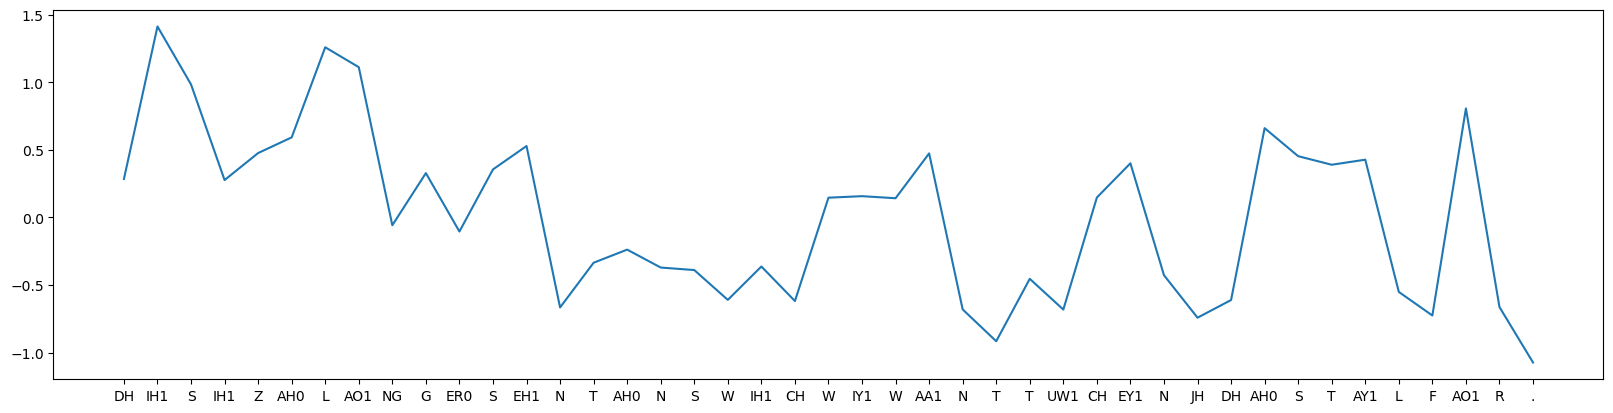

In [28]:
plt.figure().set_figwidth(20)
plt.xticks(range(len(arpa_phones)), arpa_phones)
plt.plot(energy_pred)

In [26]:
len(energy_pred)

43

In [30]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
sf.write(save_dir / 'transfer' / f'long_text_from_short.wav', output_dict[0].squeeze().cpu().numpy(), 22050, "PCM_16")

In [9]:
feats_dict = pretrained_model.collect_feats(batch)

TypeError: collect_feats() missing 3 required positional arguments: 'text_lengths', 'speech', and 'speech_lengths'

In [27]:
vowel_count = sum(phoneme in vowels for phoneme in phonemes)
batch_phone_ids = [phone_ids] * (1+vowel_count)
batch_d_factor = d_factor.unsqueeze(0).repeat(1+vowel_count, 1, 1)
batch_text = [orig_text] * (1+vowel_count)
count = 1
for i, phoneme in enumerate(phonemes):
    if phoneme in vowels:
        batch_text[count] = batch_text[count] + f'{count}{phoneme}x3'
        batch_d_factor[count][0, i] = 4.0
        count += 1

In [7]:
with torch.no_grad():
    output_dict = pretrained_model.tts.inference(text=phone_ids)
outputs, batch_text = [output_dict], [orig_text]

In [8]:
wav = output_dict['wav'].detach().cpu().numpy()

In [13]:
duration = output_dict['duration']

In [11]:
vowel_positions = [i for i, phone in enumerate(phonemes) if phone in vowels]

In [13]:
old[:10]

array([0.01004028, 0.01229858, 0.01342773, 0.01379395, 0.01278687,
       0.01147461, 0.0098877 , 0.00762939, 0.00552368, 0.003479  ])

In [14]:
new[:10]

array([0.01009708, 0.0123611 , 0.01348879, 0.01384719, 0.01282857,
       0.01152581, 0.00992997, 0.00763391, 0.00552392, 0.00348757],
      dtype=float32)

In [34]:
phonemes = ['DH', 'AE1', 'T', '.']
phone_ids = torch.tensor(id_converter.tokens2ids(phonemes), dtype=torch.int32, device=device)
phone_ids = phone_ids.unsqueeze(0).repeat(2, 1).unsqueeze(-1)

In [39]:
text_lengths = torch.tensor(
            [phone_ids.size(1)],
            dtype=torch.long,
            device=phone_ids.device,
        )

In [40]:
text_lengths

tensor([4], device='cuda:0')

In [182]:
p_factor = torch.tensor([p_factor], device=device)

In [183]:
with torch.no_grad():
    output_dict = pretrained_model.tts.inference(text=phone_ids, p_factor=p_factor)
    wav = output_dict['wav']
    sf.write(save_dir / f'You ought to be ashamed of yourselves!.wav', wav.cpu().numpy(), 22050, "PCM_16")

Pitch pred: tensor([[[ 0.4832],
         [ 0.6138],
         [ 0.3746],
         [ 0.2471],
         [ 0.4046],
         [ 0.2490],
         [ 0.4034],
         [ 0.4148],
         [ 0.4543],
         [ 1.0424],
         [ 1.1197],
         [ 1.2813],
         [ 1.2220],
         [ 0.7535],
         [ 0.3195],
         [ 0.1217],
         [-0.1238],
         [-0.0921],
         [ 0.3630],
         [-0.3430],
         [-1.0084],
         [-1.0646],
         [-1.3242],
         [-1.4642]]], device='cuda:0')
Pitch (new): tensor([[[ 0.4832],
         [ 0.6138],
         [ 0.3746],
         [ 0.2471],
         [ 0.4046],
         [ 0.2490],
         [ 0.4034],
         [ 0.4148],
         [ 0.4543],
         [ 1.0424],
         [ 1.1197],
         [ 1.2813],
         [ 1.2220],
         [ 2.2535],
         [ 0.8195],
         [ 0.6217],
         [ 0.8762],
         [ 0.4079],
         [ 0.8630],
         [ 0.1570],
         [-0.5084],
         [-0.5646],
         [-0.8242],
         [-1.464

In [75]:
sq_wavs = [torch.sum(wav*wav).cpu().item() for wav in wavs]

In [76]:
sq_wavs

[15.179880142211914,
 31.90578842163086,
 55.934356689453125,
 88.82083129882812,
 104.86000061035156,
 120.048828125,
 128.54351806640625,
 141.59689331054688,
 154.67254638671875]

In [60]:

for wav in wavs:
    print(torch.log(torch.sum(wav*wav)))

tensor(3.4628, device='cuda:0')
tensor(4.0242, device='cuda:0')
tensor(4.4866, device='cuda:0')
tensor(4.6526, device='cuda:0')
tensor(4.7879, device='cuda:0')
tensor(4.8563, device='cuda:0')
tensor(4.9530, device='cuda:0')


In [61]:
%matplotlib inline

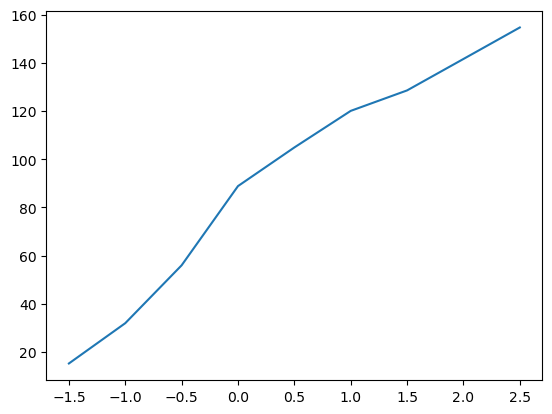

In [72]:
import matplotlib.pyplot as plt
e_facs = [x/2 for x in range(-3, 6)]
plt.plot(e_facs, [x for x in sq_wavs])
plt.show()

In [80]:
base_wav_trim, idx = librosa.effects.trim(
                y=wavs[3].cpu().numpy(),
                top_db=60,
                frame_length=1024,
                hop_length=256,
            )

In [125]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
for p, wav in zip(p_, wavs):
    plus_e = f'+{e}' if e > 0 else e
    half_e = f'+{e/2}' if e > 0 else e/2
    sf.write(save_dir / f'that.th{half_e}a{plus_e}.wav', wav.cpu().numpy(), 22050, "PCM_16")

In [96]:
ef = e_factor.squeeze().cpu().numpy().tolist()

In [100]:
durations = output_dict['duration'].squeeze().cpu().numpy().tolist()

In [128]:
hop_length = 256
base_wav = wavs[3].cpu().numpy()
mod_wav = wavs[-1].cpu().numpy()
start_pos = 0
end_pos = 0
new_wav = []
for d, e in zip(durations, ef):
    end_pos += d*hop_length
    base_segment = base_wav[start_pos:end_pos]
    mod_segment = mod_wav[start_pos:end_pos]
    amplitude_factor = math.sqrt(2 / (1 + math.exp(-e)))
    new_wav.append(base_segment * amplitude_factor)
    start_pos = end_pos
new_wav = np.concatenate(new_wav)

In [121]:
for d, e in zip(durations, ef):
    print(2 / (1 + math.exp(-e)))

1.5545997223493822
1.848283639957513
1.5545997223493822
1.0


In [129]:
sf.write(save_dir / f"that._sigm_dsp.wav", new_wav, 22050, "PCM_16")

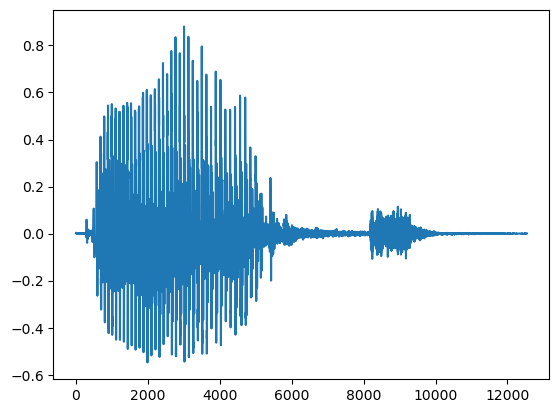

In [122]:
plt.plot(new_wav)

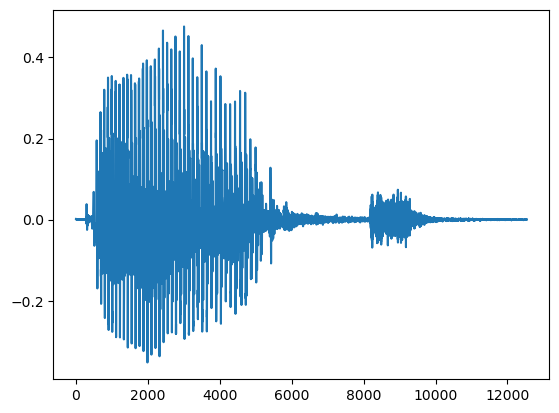

In [123]:
plt.plot(base_wav)

In [38]:
durations = output_dict['duration'].unsqueeze(0)
durations_lengths = torch.tensor(durations.size())

In [36]:
feats_lengths = torch.tensor([35], device=device)

In [43]:
base_energy, _ = pretrained_model.energy_extract(base_wav.unsqueeze(0), torch.tensor(base_wav.size()),
                                feats_lengths, durations, durations_lengths)

In [220]:
pitches = []
for wav in wavs:
    pitch, _ = pretrained_model.pitch_extract(wav.unsqueeze(0), torch.tensor(wav.size()),
                                feats_lengths, durations, durations_lengths)
    pitches.append(pitch.squeeze().mean().cpu().item())

In [234]:
new_pitches = []
for wav in new_wavs:
    pitch, _ = pretrained_model.pitch_extract(torch.tensor([wav]), torch.tensor([len(wav)]),
                                feats_lengths, durations, durations_lengths)
    new_pitches.append(pitch.squeeze().mean().cpu().item())

In [232]:

for wav, new_wav, i in zip(wavs, new_wavs, range(-4, 5)):
    shift = i*1.0
    # sf.write(save_dir / f"that.p{shift}.wav", wav.cpu().numpy(), 22050, "PCM_16")
    sf.write(save_dir / f"that.p{shift}_dsp.wav", new_wav, 22050, "PCM_16")

In [56]:
import math
for i, wav in enumerate(wavs):
    print(torch.sum(wav*wav) / math.sqrt((i+2)/2-1))

tensor(88.8208, device='cuda:0')
tensor(85.6178, device='cuda:0')
tensor(84.8873, device='cuda:0')
tensor(81.2981, device='cuda:0')
tensor(81.7510, device='cuda:0')


In [50]:
print(torch.sum(base_energy))
for energy in energies:
    print(torch.sum(energy))

tensor(1026.3350, device='cuda:0')
tensor(1183.9402, device='cuda:0')
tensor(1293.1489, device='cuda:0')
tensor(1375.7120, device='cuda:0')
tensor(1475.3696, device='cuda:0')


In [40]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
os.makedirs(save_dir, exist_ok=True)
sf.write(save_dir / f"{orig_text}_dsp.wav", wav_result, 22050, "PCM_16")

tensor([[[ 0.5454],
         [ 5.4649],
         [32.8088],
         [63.3920],
         [78.6348],
         [82.7436],
         [84.2931],
         [86.2685],
         [85.7019],
         [82.4692],
         [78.6783],
         [72.1199],
         [63.8343],
         [53.3254],
         [39.5262],
         [26.0968],
         [12.8273],
         [ 6.6415],
         [ 7.2623],
         [ 6.4622],
         [12.5029],
         [14.8022],
         [ 8.7500],
         [ 5.0235],
         [ 3.1658],
         [ 2.8651],
         [ 2.3932],
         [ 1.5994],
         [ 1.2492],
         [ 1.1724],
         [ 1.0174],
         [ 0.8575],
         [ 0.7179],
         [ 0.6042],
         [ 0.5180]]], device='cuda:0')

In [44]:
wav_result[start_pos:]

array([-0.04571102, -0.0352678 , -0.01489699, ...,  0.00032871,
        0.00042657,  0.00053737], dtype=float32)

In [26]:
import numpy as np
num_points = len(wav_edit)
x = np.linspace(0, num_points, num=num_points*4)
interpolated = np.interp(x, list(range(0, num_points)), wav_edit)

In [30]:
wav_result = np.concatenate([start_wav, interpolated, end_wav])

In [47]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
os.makedirs(save_dir, exist_ok=True)
sf.write(save_dir / f"{orig_text}_dsp.wav", wav_result, 22050, "PCM_16")

In [13]:
' '.join(phonemes)

'DH IH1 S IH1 Z AH0 V EH1 R IY0 L AO1 NG T EH1 K S T , W IH1 CH AY1 IH0 K S P EH1 K T DH AH0 M AA1 D AH0 L T UW1 R EH1 D P R AA1 P ER0 L IY0 AH0 N D N AA1 T T UW1 F AE1 S T .'

In [28]:
with torch.no_grad():
    outputs = []
    for phone_ids, d_factor in zip(batch_phone_ids, batch_d_factor):
        output_dict = pretrained_model.tts.inference(text=phone_ids, d_factor=d_factor)
        outputs.append(output_dict)

Duration pred: tensor([[ 7,  6, 12,  7,  6,  8,  6,  6,  7,  9,  7,  9,  9,  9, 10,  9,  7,  7,
          5,  5,  7, 11,  9,  9,  7,  8,  6,  6,  6,  4,  5,  6,  7,  9,  6,  7,
         15,  7,  7,  8,  9,  7,  6,  7,  7,  7,  8,  8,  7,  6,  7,  7,  6,  8,
          7,  7, 11, 10, 17, 16,  7,  9]], device='cuda:0')
Duration (new): tensor([[ 7,  6, 12,  7,  6,  8,  6,  6,  7,  9,  7,  9,  9,  9, 10,  9,  7,  7,
          5,  5,  7, 11,  9,  9,  7,  8,  6,  6,  6,  4,  5,  6,  7,  9,  6,  7,
         15,  7,  7,  8,  9,  7,  6,  7,  7,  7,  8,  8,  7,  6,  7,  7,  6,  8,
          7,  7, 11, 10, 17, 16,  7,  9]], device='cuda:0')
Duration pred: tensor([[ 7,  6, 12,  7,  6,  8,  6,  6,  7,  9,  7,  9,  9,  9, 10,  9,  7,  7,
          5,  5,  7, 11,  9,  9,  7,  8,  6,  6,  6,  4,  5,  6,  7,  9,  6,  7,
         15,  7,  7,  8,  9,  7,  6,  7,  7,  7,  8,  8,  7,  6,  7,  7,  6,  8,
          7,  7, 11, 10, 17, 16,  7,  9]], device='cuda:0')
Duration (new): tensor([[ 7, 24, 12,  7,  6, 